In [2]:
!pip install tensorflow

In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [4]:
!pip install pillow

In [5]:
# Generate data paths with labels
data_dir = 'colon_image_sets'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
df

filepaths     labels
0     colon_image_sets\colon_aca\.ipynb_checkpoints  colon_aca
1         colon_image_sets\colon_aca\colonca10.jpeg  colon_aca
2        colon_image_sets\colon_aca\colonca100.jpeg  colon_aca
3       colon_image_sets\colon_aca\colonca1000.jpeg  colon_aca
4       colon_image_sets\colon_aca\colonca1001.jpeg  colon_aca
...                                             ...        ...
4331        colon_image_sets\colon_n\colonn995.jpeg    colon_n
4332        colon_image_sets\colon_n\colonn996.jpeg    colon_n
4333        colon_image_sets\colon_n\colonn997.jpeg    colon_n
4334        colon_image_sets\colon_n\colonn998.jpeg    colon_n
4335        colon_image_sets\colon_n\colonn999.jpeg    colon_n

[4336 rows x 2 columns]

In [7]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Define image size and batch size
img_size = (224, 224)
batch_size = 16
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Define data augmentation
tr_gen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255)

# Instead of reading from a directory, use the previously created dataframe 'df'
# df = pd.read_csv('colon_image_sets')  # Remove this line

# Split dataset into train, validation, and test sets
# Use the existing 'df' variable instead of loading a new one
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.15, random_state=42)

# Create data generators
train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)  # Set color_mode to 'grayscale' if images are grayscale

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                        color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 2946 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.
Found 868 validated image filenames belonging to 2 classes.


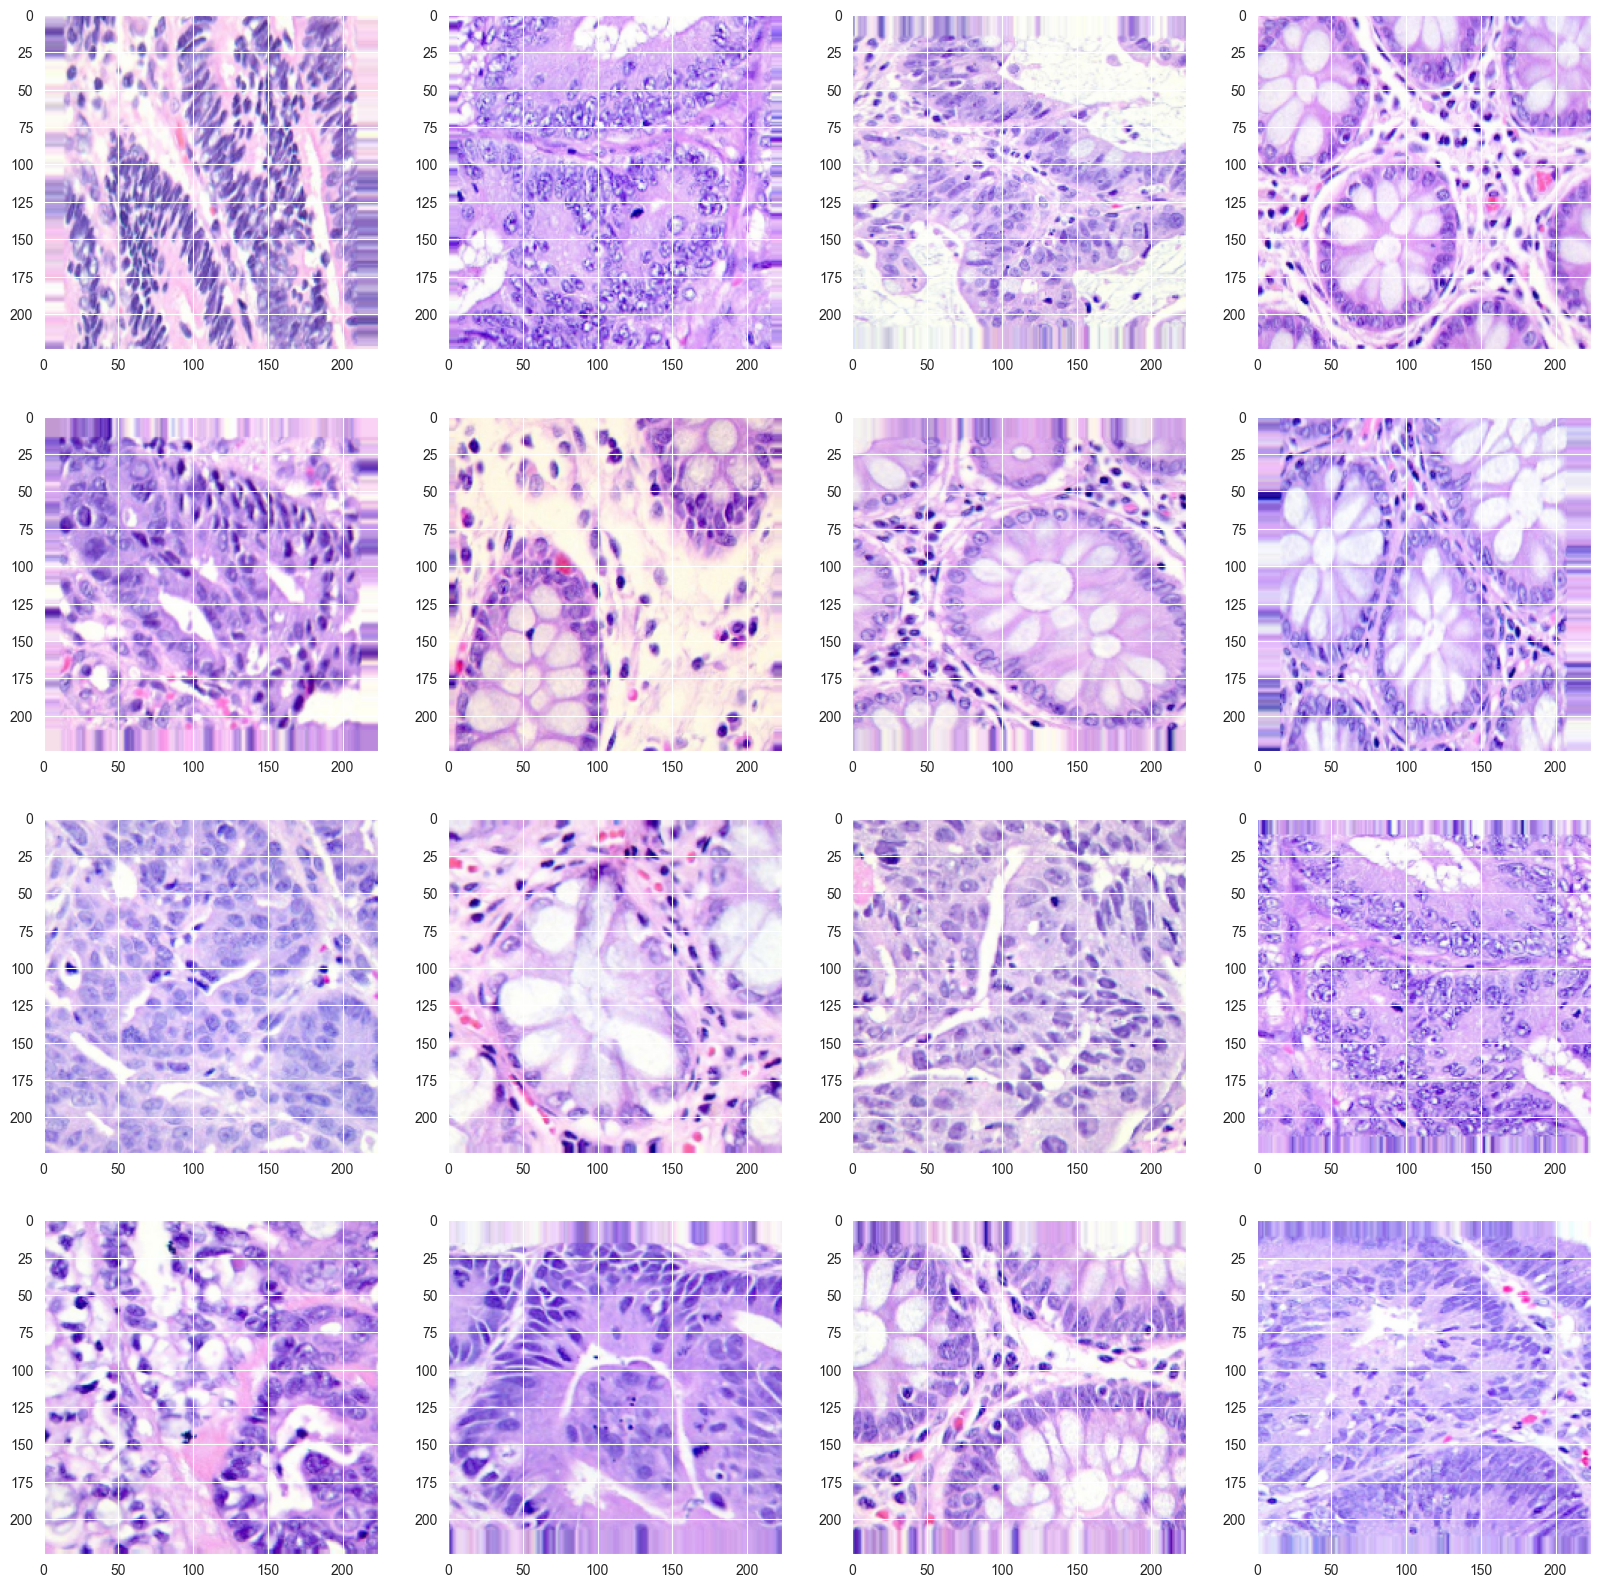

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# ... (Your generator code)

g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i]  # No scaling needed
    plt.imshow(image)

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.L2(0.016), activity_regularizer= regularizers.L1(0.006),
                bias_regularizer= regularizers.L1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,183,665 (42.66 MB)

 Trainable params: 11,093,290 (42.32 MB)

 Non-trainable params: 90,375 (353.03 KB)

In [11]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1446s 7s/step - accuracy: 0.7742 - loss: 11.4989 - val_accuracy: 0.4741 - val_loss: 5.7800
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1246s 7s/step - accuracy: 0.7106 - loss: 5.4315 - val_accuracy: 0.4741 - val_loss: 4.5224
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1234s 7s/step - accuracy: 0.7511 - loss: 4.2789 - val_accuracy: 0.9386 - val_loss: 3.6040
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1139s 6s/step - accuracy: 0.8968 - loss: 3.3749 - val_accuracy: 0.9750 - val_loss: 2.7733
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1142s 6s/step - accuracy: 0.9052 - loss: 2.6549 - val_accuracy: 0.9731 - val_loss: 2.1602
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1228s 7s/step - accuracy: 0.8758 - loss: 2.0939 - val_accuracy: 0.9981 - val_loss: 1.6375
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1143s 6s/step - accuracy: 0.8680 - loss: 1.6673 - val_accuracy: 1.0000 - val_loss: 1.2775
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 1170s 6s/step - accuracy: 0.8784 - loss: 1.3420 -

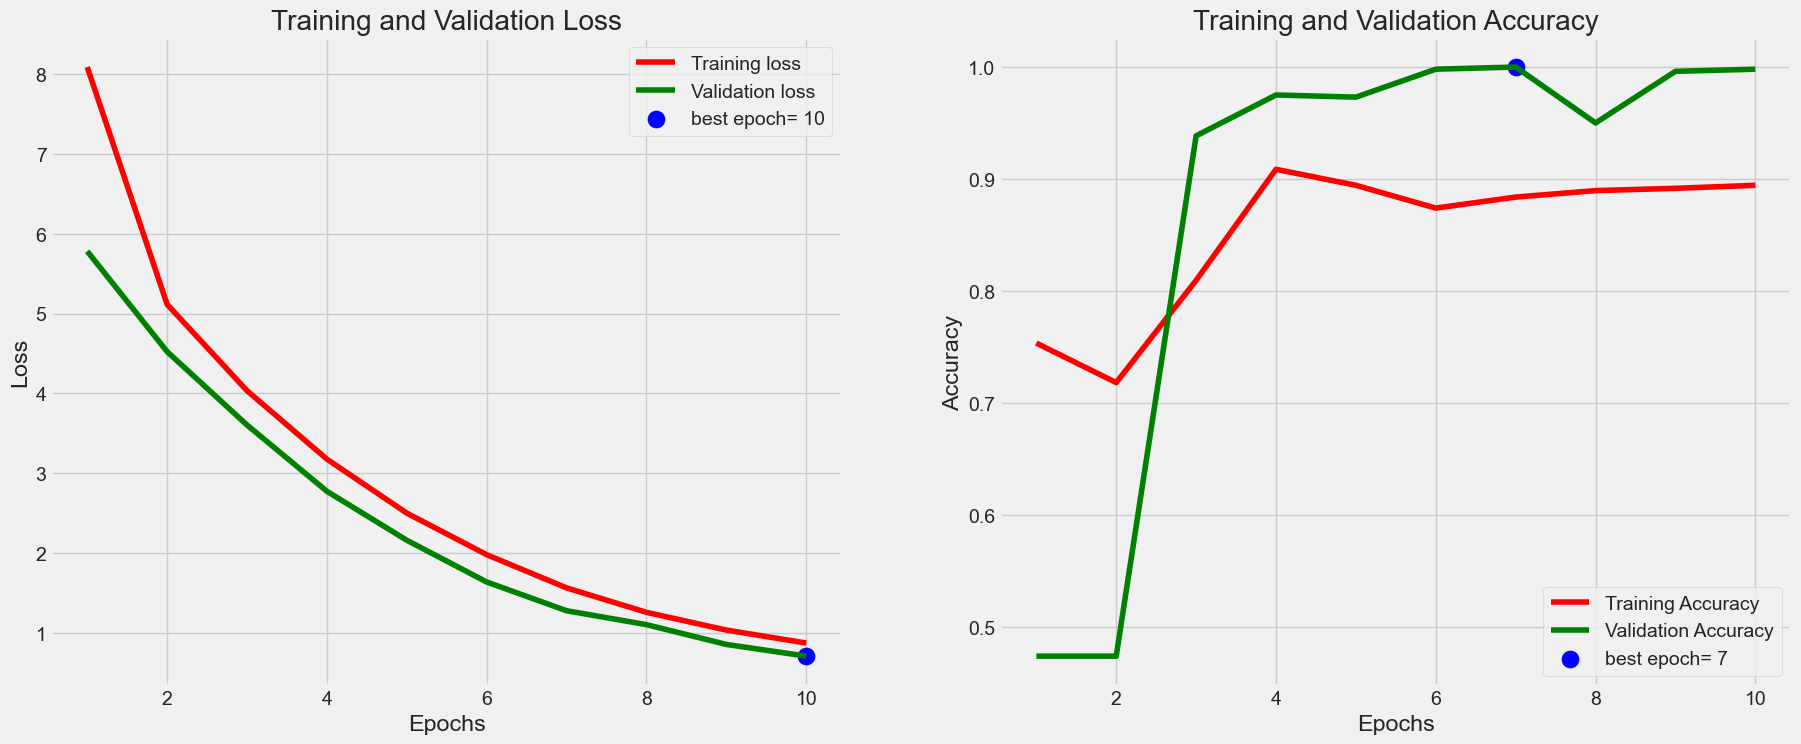

In [13]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [14]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9938 - loss: 0.7032
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 1.0000 - loss: 0.7148
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9888 - loss: 0.7179
Train Loss:  0.7034341096878052
Train Accuracy:  0.9955357313156128
--------------------
Validation Loss:  0.7110247015953064
Validation Accuracy:  1.0
--------------------
Test Loss:  0.7160822749137878
Test Accuracy:  0.9910714030265808


In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step


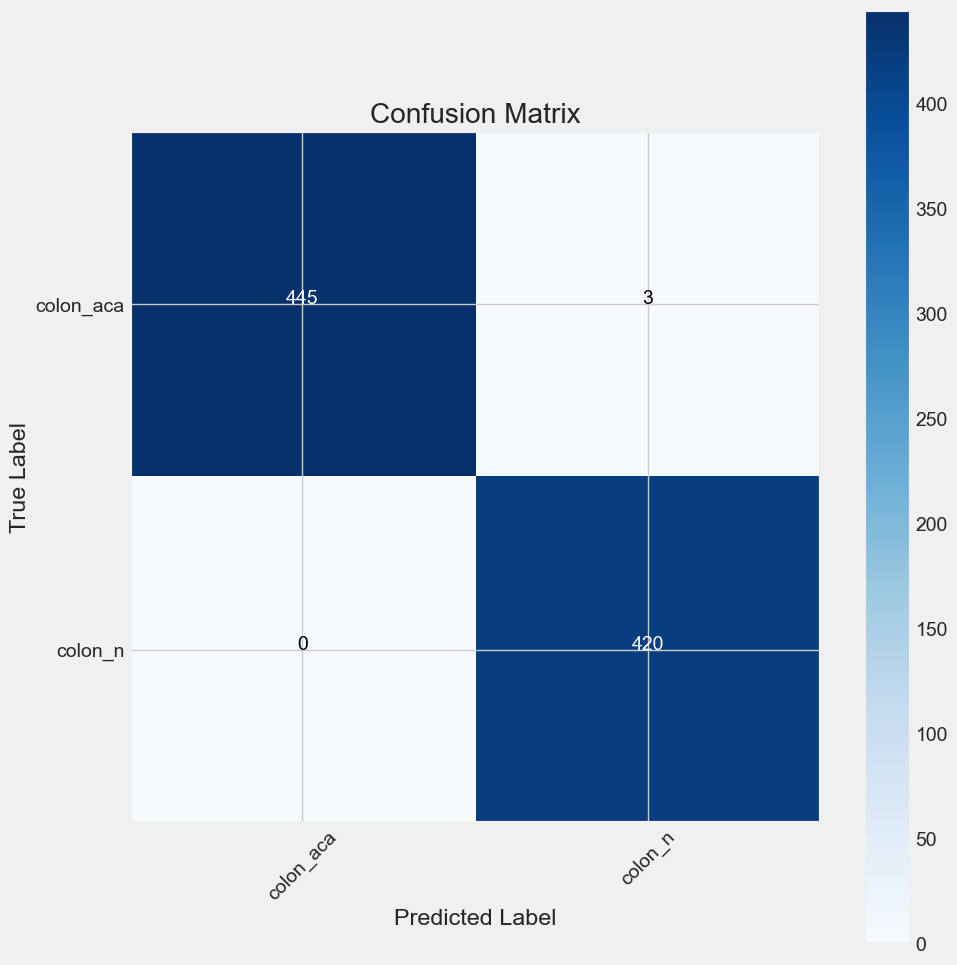

In [17]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [18]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

   colon_aca       1.00      0.99      1.00       448
     colon_n       0.99      1.00      1.00       420

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



In [35]:
#Saving the model in the new keras format
model.save('Colon_Cancer.keras')

In [37]:
loaded_model = tf.keras.models.load_model('Colon_Cancer.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [38]:
image_path = 'colon_image_sets/colon_n/colonn1005.jpeg'
image = Image.open(image_path)
# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Colon_ACA', 'Colon_N']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Colon_N
